# Fashion Recommendation System
[Data Information]   
Data Source: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78   
Raw Data Type : 720x1280x24b

[Image]   
Item-Image : n장   
Model-Image : m장

[Version]   
Based Convolutional AE, 64x64x3

## 0. Setting

### Goole Drive Connecting

In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Code Lion/Final'

/content/drive/MyDrive/Code Lion/Final


In [ ]:
!ls

 data  'Fashion Recommendation System0810.ipynb'   figure  'low version'


### Library Call

In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.3 MB/s 


In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [ ]:
import os
os.getcwd()

'd:\\Fasion_Images'

In [ ]:
# root_dir = 'D:/Fasion_Images/Train/train_itemimages/Item-Image/'
# glob(f'{root_dir}/*.jpg')

In [ ]:
# -------------Image Load & Preprocessing ------------- #
# Global Constant Definition
imgR = 64
imgC = 64
channel = 3
crop_y = (250,1000)
crop_x = (40,680)
root_dir = '/content/drive/MyDrive/Code Lion/Final/data'

# Single Image Load
def img_read(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Gamma Correction
def adjust_gamma(img, gamma=1.0): # 감마 보정 함수
    invGamma = 1.0 / gamma
    out = img.copy().astype(np.float)
    out = ((out / 255) ** invGamma) * 255
    return out.astype(np.uint8)

# Image Crop & Resize
def img_crop(img):
    # 개선점
    img = img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]
    img = cv2.resize(img, (imgR,imgC), cv2.INTER_LINEAR)
    return img

# New Sample Image Preprocessing
def New_image_preprocessing(file_name):
  smp = img_read(file_name)
  smp = cv2.resize(smp, (imgR,imgC), cv2.INTER_LINEAR)
  smp = adjust_gamma(smp, 0.8)
  smp = smp/255.0
  return smp

# Load All img from folder
def load_img_folder():
    wfiles = sorted(glob(f'{root_dir}/*_F.jpg'))
    img_list = []
    label_list = []
    for file in wfiles:
        img = img_read(file)
        img = img_crop(img)
        img = adjust_gamma(img, 0.8)
        img_list.append(img)
        label_list.append(file.split('/')[-1])
    return np.array(img_list), label_list

# -------------Image EDA & Visualization ------------- #
# plot_images
def plot_images(nRow, nCol, img_set):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  k=0
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[k+j])
      plt.axis('off')
    k += nCol
  plt.show()

# Top10 유사 이미지 시각화
def top10_visualize(img_set,top10_idx):
  fig = plt.figure()
  fig, ax = plt.subplots(2, 5, figsize=(5*3,2*3))
  plt.suptitle('Top10 Similar Images',size=20)
  k=0
  for i in range(2):
    for j in range(5):
      axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[top10_idx[i+j]])
      plt.axis('off')
    k += 5
  plt.show()

# ------------- Model Function ------------- #
def Reconstruction_Error(X_test,X_pred):
  error_list = []
  for i in range(len(X_test)):
    ele = np.mean(np.power(X_test[i] - X_pred[i], 2),axis=1).mean()
    error_list.append(ele)
  return error_list

def AVGpooling(raw_feature):
  result = []
  for i in range(raw_feature.shape[0]):
    row= []
    for j in range(raw_feature.shape[-1]):
      row.append(raw_feature[i,:,:,j].mean())
    result.append(row)
  return np.array(result)

# ------------- Recommendation System ------------- #
def Fashion_coordination(top10_result, fashion_df):
  result_df = []
  for item in top10_result:
    ele_df = pd.DataFrame(columns=fashion_df.columns)
    for col in fashion_df.columns:
      ele = fashion_df[fashion_df[col] == item]
      ele_df = pd.concat([ele_df,ele])
    result_df.append(ele_df)
  return result_df

## 1. Data Load

In [ ]:
import glob

In [ ]:
# Image DataSet Load
img_set, label_set = load_img_folder()
print('img_set.shape :',img_set.shape)
print('label_set.shape :',len(label_set))

img_set.shape : (16585, 64, 64, 3)
label_set.shape : 16585


In [ ]:
# Image Information
type(img_set), round(img_set.mean(),4)

(numpy.ndarray, 215.0564)

In [ ]:
# Label Information
type(label_set), label_set[:4]

(list,
 ['Item-Image\\0928015_F.jpg',
  'Item-Image\\0929029_F.jpg',
  'Item-Image\\1008001_F.jpg',
  'Item-Image\\1008004_F.jpg'])

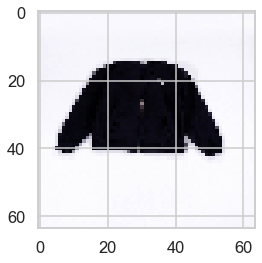

In [ ]:
# Image Sample
plt.imshow(img_set[200])

<Figure size 432x288 with 0 Axes>

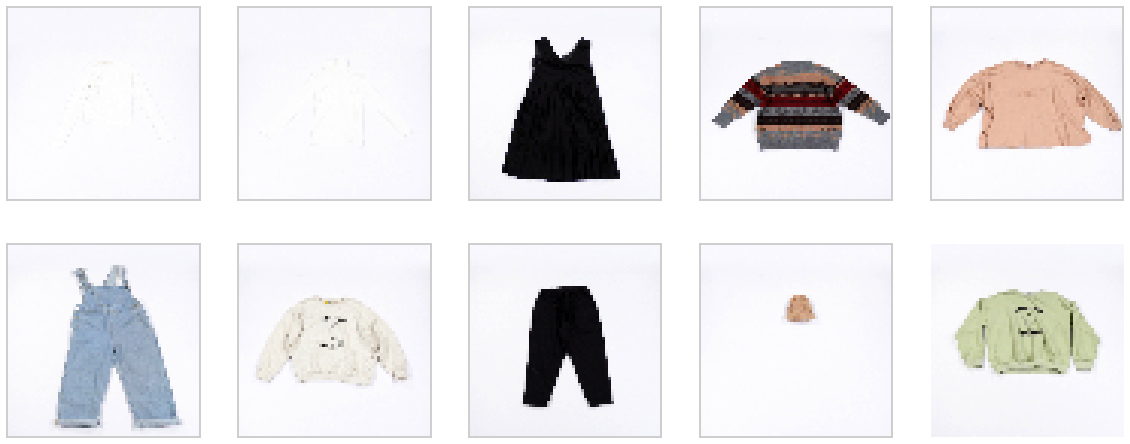

In [ ]:
# Multi Image Samples
_ = plot_images(2,5,img_set)

## 2. Data Preprocessing

In [ ]:
# Data Normalization
img_scaled = img_set / 255.0
print('Raw Image Format :',img_set.shape, img_set.mean())
print('Scaled Image Format :',img_scaled.shape, img_scaled.mean())

Raw Image Format : (16585, 64, 64, 3) 215.05644116129974
Scaled Image Format : (16585, 64, 64, 3) 0.8433585927894048


In [ ]:
# Train, Test Data Split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(img_scaled, label_set, random_state=42, test_size=0.2, shuffle=True)
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(13268, 64, 64, 3) 13268
(3317, 64, 64, 3) 3317


## 3. Convolutional Autoencoder Modeling

### Encoder

In [ ]:
# Encoder Part Modeling
tf.keras.backend.clear_session()
encoder_input = Input(shape=(imgR,imgC,channel))

L1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
L2 = MaxPooling2D((2, 2))(L1)
L3 = Conv2D(16, (3, 3), activation='relu', padding='same')(L2)
L4 = MaxPooling2D((2, 2))(L3)
L5 = Conv2D(8, (3, 3), activation='relu', padding='same')(L4)
L6 = MaxPooling2D((2, 2))(L5)
L7 = Conv2D(8, (3, 3), activation='relu', padding='same')(L6)
L8 = MaxPooling2D((2, 2))(L7)

encoder_output = L8

In [ ]:
# Encoder Summary()
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         1160  

In [ ]:
pip install pydot

In [ ]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Plot Encoder Diagram
plot_model(encoder, to_file='figure/Eecoder0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Decoder

In [ ]:
# Decoder Part Modeling
decoder_input = Input(shape=(4,4,8))  # Decoder의 Input Shape는 Hard Coding이 필요함. (개선점)

L9 = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
L10 = UpSampling2D((2, 2))(L9)
L11 = Conv2D(8, (3, 3), activation='relu', padding='same')(L10)
L12 = UpSampling2D((2, 2))(L11)
L13 = Conv2D(16, (3, 3), activation='relu', padding='same')(L12)
L14 = UpSampling2D((2, 2))(L13)
L15 = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(L14)
L16 = UpSampling2D((2, 2))(L15)
L17 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(L16)

decoder_output = L17

In [ ]:
# Decoder Summary()
decoder = keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 8)]         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        1168

In [ ]:
# Plot Decoder Diagram
plot_model(decoder, to_file='figure/Decoder0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### AutoEncoder (Encoder + Decoder)

In [ ]:
# Convolutional Autoencoder Modeling
# Connecting Encoder & Decoder Part

init_input = Input(shape=(imgR,imgC,channel))
connect_input = encoder(init_input)
connect_output = decoder(connect_input)

model = keras.Model(init_input, connect_output)

In [ ]:
# Model Compile
model.compile(optimizer='Adam',loss='binary_crossentropy')

In [ ]:
# Convolutional Autoencoder Summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 4, 4, 8)           7264      
                                                                 
 model_1 (Functional)        (None, 64, 64, 3)         7843      
                                                                 
Total params: 15,107
Trainable params: 15,107
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Plot ConvAE Diagram
plot_model(model, to_file='figure/ConvAE0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'Training-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 10번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
patience_epoch = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epoch)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
# TQDM Tracking Conv-AE Model Training
nb_epochs = 100
batch_size = 64

start = time.time()
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history
end = time.time()

In [ ]:
# Print Training Time
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 12:41:57


In [ ]:
# Training History DataFrame
df_hist = pd.DataFrame(history)
df_hist.tail()

,loss,val_loss
95,0.215168,0.217177
96,0.215134,0.217394
97,0.215113,0.217406
98,0.215106,0.217107
99,0.215111,0.217343


In [ ]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,val_loss
98,0.215106,0.217107


In [ ]:
# Save Model
# Encoder Part Save
encoder.save('model_save/Encoder_0810/')

# Decoder Part Save
decoder.save('model_save/Decoder_0810/')

# Convolutional Autoencoder Model Save
model.save('model_save/ConvAE_0810/')

INFO:tensorflow:Assets written to: model_save/Encoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Encoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Decoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Decoder_0810/assets


INFO:tensorflow:Assets written to: model_save/ConvAE_0810/assets


INFO:tensorflow:Assets written to: model_save/ConvAE_0810/assets


In [ ]:
# Load Model
encoder = keras.models.load_model('model_save/Encoder_0810/')
decoder = keras.models.load_model('model_save/Decoder_0810/')
model = keras.models.load_model('model_save/ConvAE_0810/')

## 4. Performance Evaluation

In [ ]:
# Loss Learning Curve
plt.figure(figsize=(8,6))
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_epoch, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
plt.show()

<Figure size 432x288 with 0 Axes>

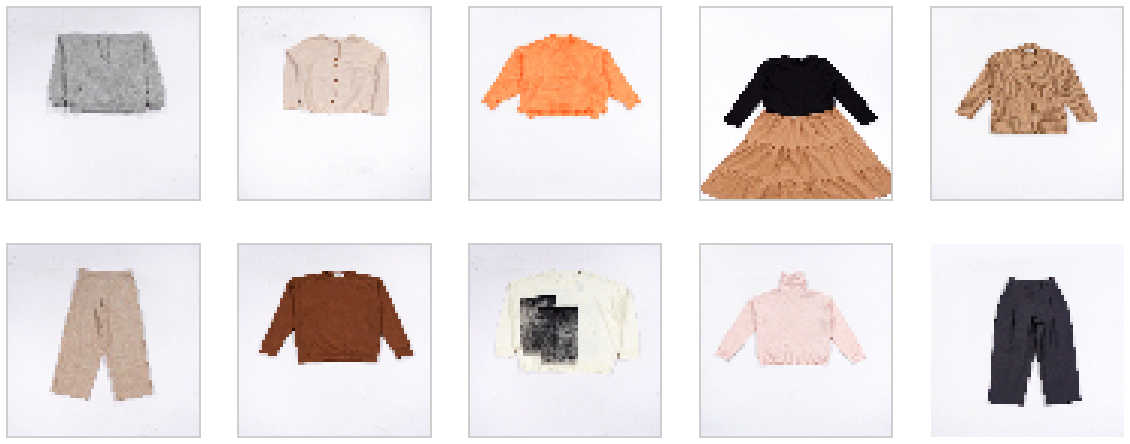

In [ ]:
# Test Image Samples
_ = plot_images(2,5,X_test)

In [ ]:
# Test Data Evaluation
test_loss = model.evaluate(X_test,X_test)
print('test loss :',np.round(test_loss,4))

104/104 [==============================] - 21s 140ms/step - loss: 0.2159
test loss : 0.2159


In [ ]:
# Test Data Prediction(Reconstruction)
X_pred = model.predict(X_test)
X_pred.shape,round(X_pred.mean(),4)

104/104 [==============================] - 15s 130ms/step


((3317, 64, 64, 3), 0.8475)

<Figure size 432x288 with 0 Axes>

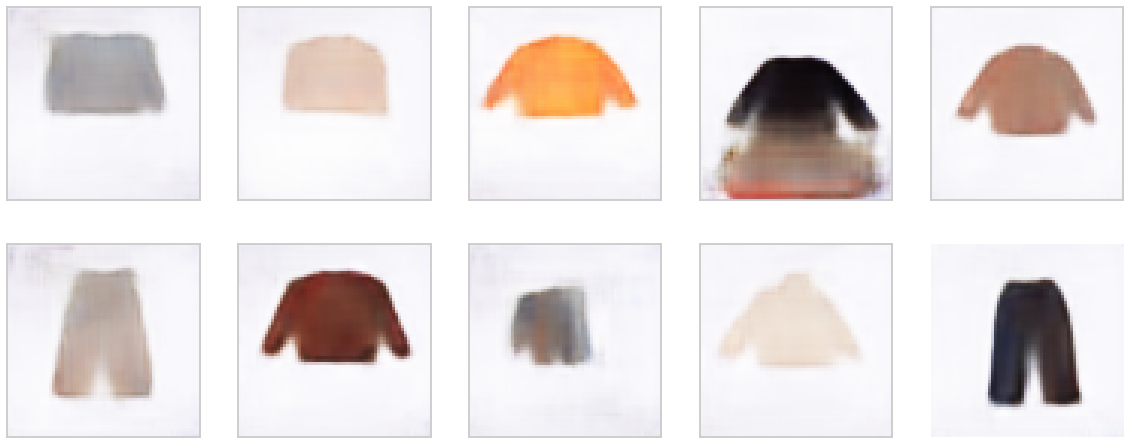

In [ ]:
# Prediction Image Samples
_ = plot_images(2,5,X_pred)

In [ ]:
# Reconstruction Error 
X_error = Reconstruction_Error(X_test,X_pred)
len(X_error), type(X_error)

(3317, list)

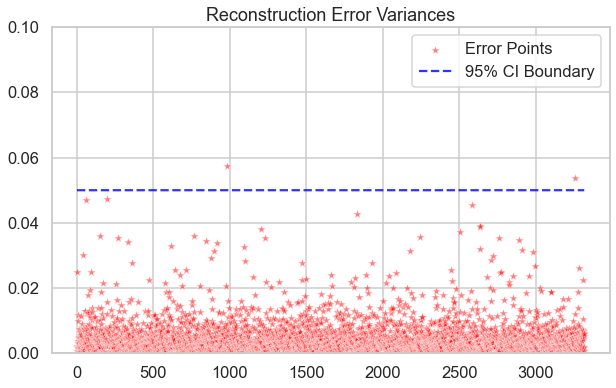

In [ ]:
# Reconstruction Error Visaulization
X_loop = np.arange(len(X_error))
boundary = 0.05

plt.figure(figsize=(10,6))
sns.scatterplot(X_loop, X_error, color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(X_loop, boundary, color='blue', linestyle='--', label='95% CI Boundary', alpha=0.8)
plt.title('Reconstruction Error Variances', size=18)
plt.legend(loc="upper right")
plt.ylim(0.00,0.10)
plt.show()

## 5. Latent Space Projection

In [ ]:
# Raw Latent Feature
raw_feature = encoder.predict(img_scaled)
raw_feature.shape, type(raw_feature)

519/519 [==============================] - 28s 52ms/step


((16585, 4, 4, 8), numpy.ndarray)

In [ ]:
# Deep Compact Latent 8 Features 
latent_feature = AVGpooling(raw_feature)
latent_feature.shape, type(latent_feature)

((16585, 8), numpy.ndarray)

In [ ]:
# Latent Feature DataFrame
comp_list = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8','label']
df = pd.DataFrame(latent_feature)
df = pd.concat([df,pd.Series(label_set)],axis=1)
df.columns = comp_list
print('df.shape :',df.shape)
df.head()

df.shape : (16585, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,3.687016,0.438862,4.726101,1.260007,1.113906,1.261978,5.113382,0.480564,Item-Image\0928015_F.jpg
1,3.666209,0.488873,4.733748,1.271945,1.101050,1.258321,5.098758,0.474383,Item-Image\0929029_F.jpg
2,6.285357,9.151548,7.183553,4.041777,1.721167,5.535714,4.046946,5.844827,Item-Image\1008001_F.jpg
3,6.195465,7.072281,6.918031,3.139334,2.448922,4.795747,4.550263,4.415133,Item-Image\1008004_F.jpg
4,6.184473,4.984277,6.060486,2.382550,2.053794,4.065562,4.667767,3.056309,Item-Image\1008006_F.jpg


In [ ]:
# Latent Feature DataFrame export to csv
df.to_csv('D:/Fasion_Images/latent_feature_0812.csv',index=False)

## 6. Similarity Calculation & Top10 Item Return

In [ ]:
# Latent Feature DataFrame load
df = pd.read_csv('D:/Fasion_Images/latent_feature_0812.csv')
print(df.shape)
df.head()

(16585, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,3.687016,0.438862,4.726101,1.260007,1.113906,1.261978,5.113382,0.480564,Item-Image\0928015_F.jpg
1,3.666209,0.488873,4.733748,1.271945,1.101050,1.258321,5.098758,0.474383,Item-Image\0929029_F.jpg
2,6.285356,9.151548,7.183553,4.041777,1.721167,5.535714,4.046946,5.844827,Item-Image\1008001_F.jpg
3,6.195465,7.072281,6.918031,3.139334,2.448922,4.795747,4.550263,4.415133,Item-Image\1008004_F.jpg
4,6.184473,4.984277,6.060486,2.382550,2.053794,4.065562,4.667767,3.056309,Item-Image\1008006_F.jpg


In [ ]:
# Latent Feature Data & Label Split
data = df.drop('label',axis=1)
label = df['label']
print(data.shape, label.shape)

(16585, 8) (16585,)


### Cosine Similarity

In [ ]:
data = data.astype('float32')

In [ ]:
# Cosine Similarity Computation
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(data, data)
print('cosine_matrix.shape :',cosine_matrix.shape)
cosine_matrix[:4,:4]

cosine_matrix.shape : (16585, 16585)


array([[1.0000001 , 0.99997455, 0.72665703, 0.8061393 ],
       [0.99997455, 1.0000002 , 0.7298862 , 0.8087659 ],
       [0.72665703, 0.7298862 , 0.9999999 , 0.98992836],
       [0.8061393 , 0.8087659 , 0.98992836, 1.0000001 ]], dtype=float32)

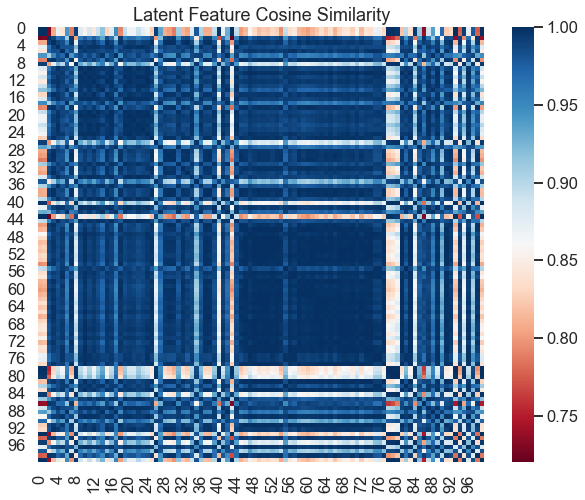

In [ ]:
# Cosine Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Cosine Similarity')
sns.heatmap(cosine_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플 추출
sample_idx = np.random.choice(np.arange(df.shape[0]),1)[0]
sample = data.loc[sample_idx,:].values.reshape(1,-1)
print('sample_idx :',sample_idx)

sample_idx : 15795


In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_cosine_sim = cosine_similarity(sample, data)

print('sample_cosine_sim.shape :',sample_cosine_sim.shape)

sample_cosine_sim.shape : (1, 16585)


In [ ]:
# # 새로운 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
# smp = New_image_preprocessing('sample.jpg')
# smp_emb = encoder.predict(np.reshape(smp,(1,64,64,3)))
# smp_comp = AVGpooling(smp_emb)
# print('smp.shape :',smp.shape)
# plt.imshow(smp)

# sample_cosine_sim = cosine_similarity(smp_comp, data)
# print('sample_cosine_sim.shape :',sample_cosine_sim.shape)
# print()

In [ ]:
# Define Sample Similarity DataFrame
df_cosine = pd.DataFrame(sample_cosine_sim.T, index=df.index, columns=['sample'])
print('df_cosine.shape :',df_cosine.shape)
df_cosine.head(4)

df_cosine.shape : (16585, 1)


,sample
0,0.987771
1,0.988551
2,0.814919
3,0.879894


In [ ]:
# # Return Top10 Similar Items
# top10_idx_cosine = df_cosine['sample'].nlargest(10).index
# print('top10_idx_cosine :',top10_idx_cosine)
# print(label[top10_idx_cosine].values)

In [ ]:
# Return Top10 Similar Items
top10_idx_cosine = df_cosine['sample'].nlargest(10).index
top10_label_cosine = label[top10_idx_cosine].values
print('top10_idx_cosine :',top10_idx_cosine)
print(top10_label_cosine)

top10_idx_cosine : Int64Index([15795, 8788, 8484, 13991, 12616, 5577, 14043, 7352, 8795, 15246], dtype='int64')
['Item-Image\\1210461_F.jpg' 'Item-Image\\1112437_F.jpg'
 'Item-Image\\1112097_F.jpg' 'Item-Image\\1202302_F.jpg'
 'Item-Image\\1126130_F.jpg' 'Item-Image\\1103263_F.jpg'
 'Item-Image\\1202367_F.jpg' 'Item-Image\\1109439_F.jpg'
 'Item-Image\\1112445_F.jpg' 'Item-Image\\1209081_F.jpg']


Item-Image\1210461_F.jpg


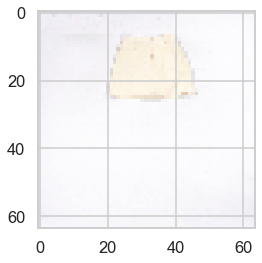

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

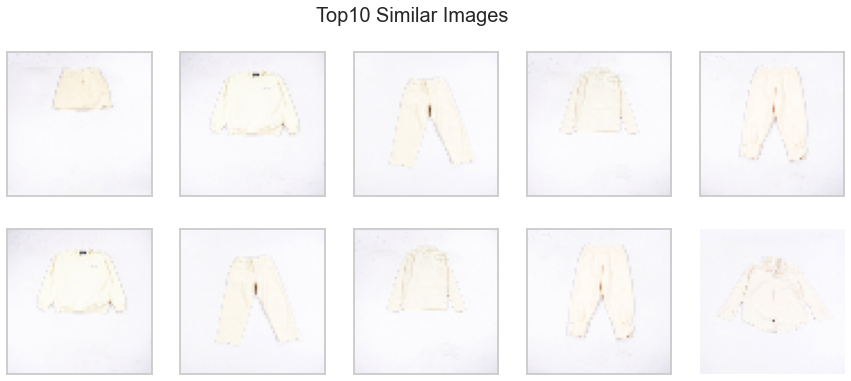

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_cosine)

### Euclidean Distance Calculation

In [ ]:
# Euclidean Distance Calculation
from sklearn.metrics.pairwise import euclidean_distances

ec_matrix = 1 / euclidean_distances(data, data)
print('ec_matrix.shape :',ec_matrix.shape)
ec_matrix[:4,:4]

ec_matrix.shape : (16585, 16585)


array([[        inf, 16.746716  ,  0.08304955,  0.10617966],
       [16.746716  ,         inf,  0.08327436,  0.10650531],
       [ 0.08304955,  0.08327436,         inf,  0.3411783 ],
       [ 0.10617966,  0.10650531,  0.3411783 ,         inf]],
      dtype=float32)

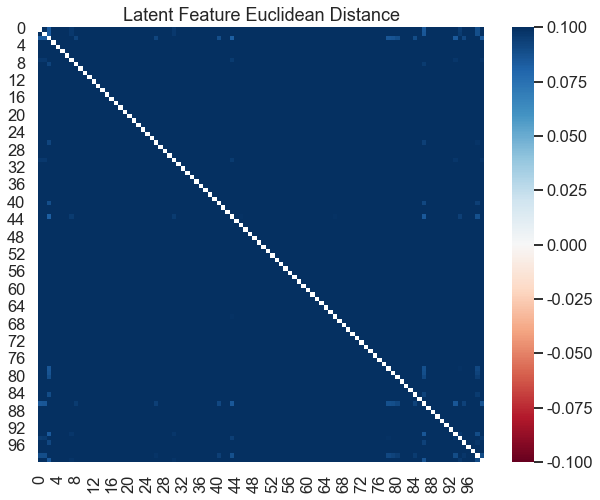

In [ ]:
# Euclidean Distance Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Euclidean Distance')
sns.heatmap(ec_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 유클리디안 거리 계산식
sample_ec_distance = 1 / euclidean_distances(sample, data)

print('sample_ec_distance.shape :',sample_ec_distance.shape)

sample_ec_distance.shape : (1, 16585)


In [ ]:
# Define Sample Similarity DataFrame
df_ec = pd.DataFrame(sample_ec_distance.T, index=df.index, columns=['sample'])
print('df_ec.shape :',df_ec.shape)
df_ec.head(4)

df_ec.shape : (16585, 1)


,sample
0,0.663749
1,0.678693
2,0.093651
3,0.124183


In [ ]:
# Return Top10 Similar Items
top10_idx_ec = df_ec['sample'].nlargest(10).index
print('top10_idx_ec :',top10_idx_ec)
print(label[top10_idx_ec].values)

top10_idx_ec : Int64Index([15795, 8484, 8788, 13991, 14043, 15246, 5577, 12616, 2607, 8107], dtype='int64')
['Item-Image\\1210461_F.jpg' 'Item-Image\\1112097_F.jpg'
 'Item-Image\\1112437_F.jpg' 'Item-Image\\1202302_F.jpg'
 'Item-Image\\1202367_F.jpg' 'Item-Image\\1209081_F.jpg'
 'Item-Image\\1103263_F.jpg' 'Item-Image\\1126130_F.jpg'
 'Item-Image\\1021144_F.jpg' 'Item-Image\\1111340_F.jpg']


Item-Image\1210461_F.jpg


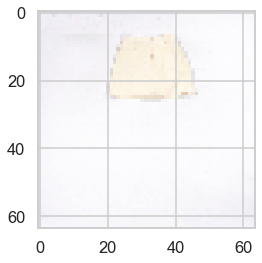

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

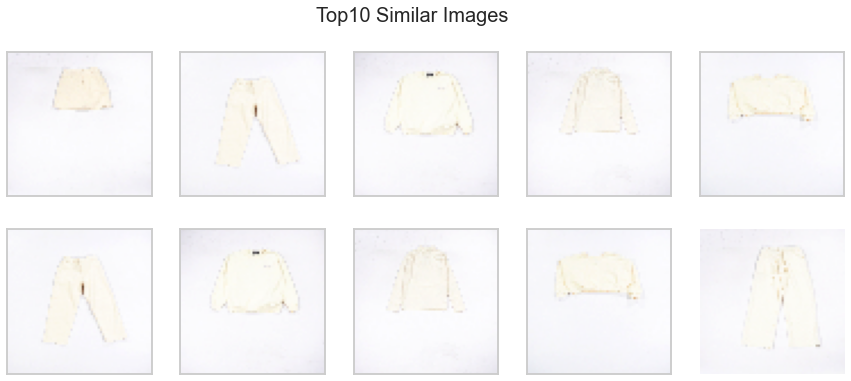

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_ec)

### Pearson Similarity

In [ ]:
# Pearson Similarity Computation
pearson_sim = np.corrcoef(data.to_numpy())
print('pearson_sim.shape :',pearson_sim.shape)
pearson_sim[:4,:4]

pearson_sim.shape : (16585, 16585)


array([[ 1.        ,  0.99994307, -0.01263006,  0.32509091],
       [ 0.99994307,  1.        , -0.00509651,  0.33175303],
       [-0.01263006, -0.00509651,  1.        ,  0.92293822],
       [ 0.32509091,  0.33175303,  0.92293822,  1.        ]])

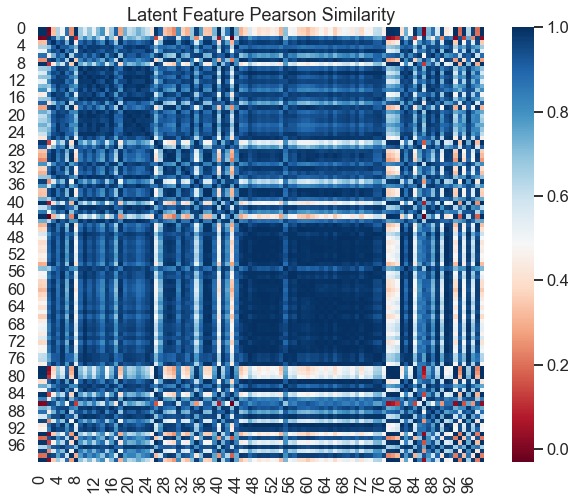

In [ ]:
# Pearson Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Pearson Similarity')
sns.heatmap(pearson_sim[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_pearson_sim = np.corrcoef(x=data.to_numpy(),y=sample)

print('sample_pearson_sim.shape :',sample_pearson_sim.shape)

sample_pearson_sim.shape : (16586, 16586)


In [ ]:
# Define Sample Similarity DataFrame
df_pearson = pd.DataFrame(sample_pearson_sim[-1,:-1], index=df.index, columns=['sample'])
print('df_pearson.shape :',df_pearson.shape)
df_pearson.head(4)

df_pearson.shape : (16585, 1)


,sample
0,0.976054
1,0.977572
2,0.183910
3,0.508852


In [ ]:
# Return Top10 Similar Items
top10_idx_pearson = df_pearson['sample'].nlargest(10).index
print('top10_idx_pearson :',top10_idx_pearson)
print(label[top10_idx_pearson].values)

top10_idx_pearson : Int64Index([15795, 4925, 13991, 8810, 8484, 15250, 8107, 7352, 8788, 15242], dtype='int64')
['Item-Image\\1210461_F.jpg' 'Item-Image\\1030156_F.jpg'
 'Item-Image\\1202302_F.jpg' 'Item-Image\\1112468_F.jpg'
 'Item-Image\\1112097_F.jpg' 'Item-Image\\1209085_F.jpg'
 'Item-Image\\1111340_F.jpg' 'Item-Image\\1109439_F.jpg'
 'Item-Image\\1112437_F.jpg' 'Item-Image\\1209077_F.jpg']


Item-Image\1210461_F.jpg


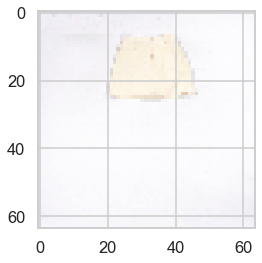

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

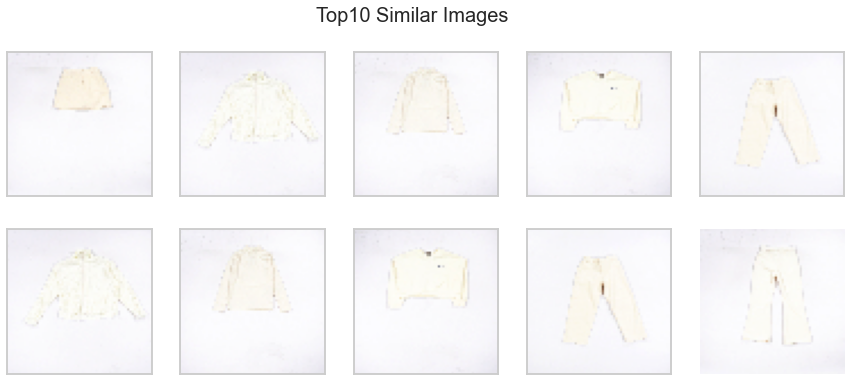

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_pearson)

## 7. Fashion Coordination Recommendation

### Fashion Coordination Dataframe Design

In [ ]:
# fashion coordination dataframe
fashion_df = pd.read_csv('D:/Fasion_Images/uni_wearing.csv')
print('fashion_df.shape :',fashion_df.shape)
fashion_df.head()

fashion_df.shape : (18040, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013.0,1008011,NaN,1008012.0,NaN
1,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449.0,1029157,NaN,1029107.0,NaN
2,1030_1030_720_A_A003_232_220_222_A003_000.jpg,1029442.0,1029411,NaN,1029109.0,NaN
3,1030_1030_720_B_B002_232_221_223_B002_000.jpg,1029434.0,1029073,NaN,1029141.0,NaN
4,1030_1030_720_B_B003_232_227_223_B003_000.jpg,1029431.0,1029255,NaN,1029142.0,NaN


In [ ]:
# fashion dataframe Information
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040 entries, 0 to 18039
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wearing    18040 non-null  object 
 1   hat        32 non-null     float64
 2   main_top   18040 non-null  int64  
 3   inner_top  2838 non-null   float64
 4   bottom     16224 non-null  float64
 5   shoes      125 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 845.8+ KB


In [ ]:
# fashion dataframe 
print(fashion_df.isna().sum())

wearing          0
hat          18008
main_top         0
inner_top    15202
bottom        1816
shoes        17915
dtype: int64


In [ ]:
# fashion dataframe Missing Value Imputation
fashion_df.fillna(0,inplace=True)
print('Remain Missing Value :',fashion_df.isna().sum().sum())

Remain Missing Value : 0


In [ ]:
# fashion data preprocessing
fashion_df.iloc[:,1:] = fashion_df.iloc[:,1:].astype(int)
fashion_df.head()

,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,0,1008012,0
1,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,0,1029107,0
2,1030_1030_720_A_A003_232_220_222_A003_000.jpg,1029442,1029411,0,1029109,0
3,1030_1030_720_B_B002_232_221_223_B002_000.jpg,1029434,1029073,0,1029141,0
4,1030_1030_720_B_B003_232_227_223_B003_000.jpg,1029431,1029255,0,1029142,0


### Match the coordination

In [ ]:
# top10 label by cosine similarity
top10_label_cosine

array(['Item-Image\\1210461_F.jpg', 'Item-Image\\1112437_F.jpg',
       'Item-Image\\1112097_F.jpg', 'Item-Image\\1202302_F.jpg',
       'Item-Image\\1126130_F.jpg', 'Item-Image\\1103263_F.jpg',
       'Item-Image\\1202367_F.jpg', 'Item-Image\\1109439_F.jpg',
       'Item-Image\\1112445_F.jpg', 'Item-Image\\1209081_F.jpg'],
      dtype=object)

In [ ]:
# top10 label preprocessing
top10_result_cosine = list(map(lambda x : int(x.split('\\')[1][:7]), top10_label_cosine))
top10_result_cosine

[1210461,
 1112437,
 1112097,
 1202302,
 1126130,
 1103263,
 1202367,
 1109439,
 1112445,
 1209081]

In [ ]:
# top10 Recommendation Result
recomm_df = Fashion_coordination(top10_result_cosine, fashion_df)
print('recomm_df :',len(recomm_df),'DataFrame')
for i in range(len(recomm_df)):
  print(f"{i+1} item's coordination cases :",recomm_df[i].shape[0])

recomm_df : 10 DataFrame
1 item's coordination cases : 3
2 item's coordination cases : 1
3 item's coordination cases : 6
4 item's coordination cases : 1
5 item's coordination cases : 2
6 item's coordination cases : 1
7 item's coordination cases : 1
8 item's coordination cases : 1
9 item's coordination cases : 1
10 item's coordination cases : 5


In [ ]:
# First Similar Item Coordination Info
recomm_df[0].head()

,wearing,hat,main_top,inner_top,bottom,shoes
17544,1210_1210_720_B_B117_620_627_B117_000.jpg,0,1210008,0,1210461,0
17545,1210_1210_720_B_B119_620_627_B119_000.jpg,0,1210007,0,1210461,0
17546,1210_1210_720_B_B120_622_627_B120_000.jpg,0,1210046,0,1210461,0


In [ ]:
# Total Similar Item Coordination DataFrame
recomm_total = pd.concat(recomm_df,axis=0)
recomm_total.reset_index(drop=True,)
print('recomm_total.shape :',recomm_total.shape)
recomm_total.head()

### Recommendation Service Output Result

In [ ]:
pwd

'd:\\Fasion_Images'

In [ ]:
model_dir = 'D:/Fasion_Images/Train/train_modelimages/Model-Image_deid/'

<Figure size 432x288 with 0 Axes>

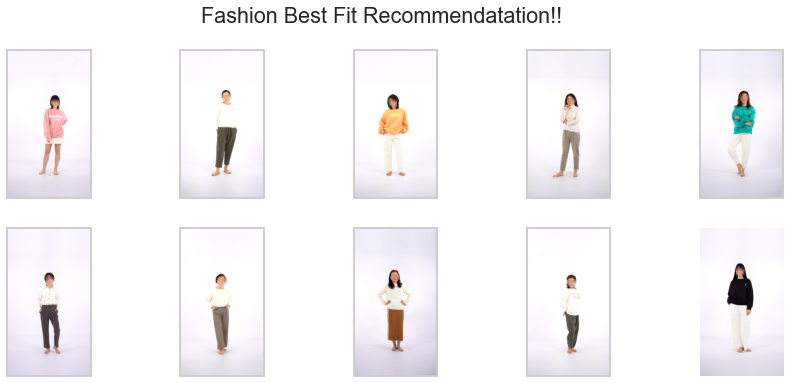

In [ ]:
# Recommendation Service Output Result : 1
count = 0
fig = plt.figure()
fig, ax = plt.subplots(2,5,figsize=(8*3,2*3))
plt.suptitle('Fashion Best Fit Recommendatation!!')
for i in range(2):
  for j in range(5):
    axis = ax[i,j]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    try:
      fashion_img_name = recomm_df[count].iloc[0,0]
      img = img_read(model_dir + '/' + fashion_img_name)
      axis.imshow(img)
      plt.axis('off')
    except:
      pass
    count+=1
plt.show()

In [ ]:
# Recommendation Service Output Result : 2
count = 0
fig = plt.figure()
fig, ax = plt.subplots(2,5,figsize=(5*3,2*3))
plt.suptitle('Fashion Best Fit Recommendatation!!')
for i in range(2):
  for j in range(5):
    axis = ax[i,j]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    try:
      fashion_img_name = recomm_total.iloc[count,0]
      img = img_read(model_dir + '/' + fashion_img_name)
      axis.imshow(img)
      plt.axis('off')
    except:
      pass
    count+=1
plt.show()